In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from matplotlib.animation import FuncAnimation
import pandas as pd
import time

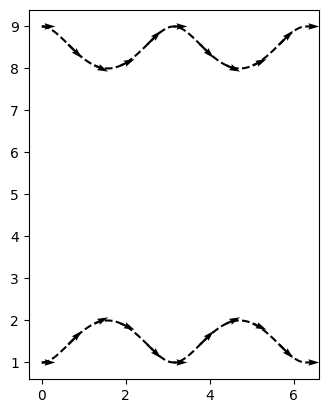

In [12]:
H = 10
W = 2 * np.pi
a, b, = 2, 1
oval_vert_dist = lambda a, b, theta: abs(np.sqrt(a**2*np.sin(theta)**2 + b**2*np.cos(theta)**2))
lower_bound = lambda a, b, theta: 0 + oval_vert_dist(a, b, theta)
upper_bound = lambda a, b, theta: H - oval_vert_dist(a, b, theta)

def numerical_derivative(a, b, theta, func, h=1e-5):
    f_plus = func(a, b, theta + h)
    f_minus = func(a, b, theta - h)
    return (f_plus - f_minus)/(2*h)

theta_grid = np.linspace(0, W, 301)
tangent_theta_grid = np.linspace(0, W, 11)
lower_bound_tangent_vectors = np.array([[1, numerical_derivative(a, b, th, lower_bound)] for th in tangent_theta_grid])
upper_bound_tangent_vectors = np.array([[1, numerical_derivative(a, b, th, upper_bound)] for th in tangent_theta_grid])
fig, ax = plt.subplots()
ax.plot(theta_grid, lower_bound(a, b, theta_grid), color='black', linestyle='--')
ax.plot(theta_grid, upper_bound(a, b, theta_grid), color='black', linestyle='--')
ax.quiver(tangent_theta_grid, 
           [lower_bound(a, b, th) for th in tangent_theta_grid], 
           lower_bound_tangent_vectors[:, 0], lower_bound_tangent_vectors[:, 1])
ax.quiver(tangent_theta_grid, 
           [upper_bound(a, b, th) for th in tangent_theta_grid], 
           upper_bound_tangent_vectors[:, 0], upper_bound_tangent_vectors[:, 1])
ax.set_aspect('equal')


In [26]:
def find_intersection(p0, p1, boundary_function, a, b):
    # Define the quantities I'm going to need
    theta0, theta1 = p0[0], p1[0]
    dtheta = theta1 - theta0
    y0, y1 = p0[1], p1[1]
    dy = y1 - y0

    # Define a function to solve for when the position of point and boundary cross
    def error(t):
        error = boundary_function(a, b, theta0 + t*dtheta) - (y0 + t*dy)
        return error
    solution = root_scalar(error, bracket=[0,1], method='bisect')

    if solution.converged:
        t_sol = solution.root
        theta_sol = theta0 + t_sol*dtheta
        y_sol = y0 + t_sol*dy
        collision_point = np.array([theta_sol, y_sol])
        return collision_point
    
def give_reflection(p_intersect, p1, boundary_func, a, b):

    theta_intersect = p_intersect[0]
    dy_dtheta = numerical_derivative(a, b, theta_intersect, boundary_func)[0]
    tangent = np.array([1, dy_dtheta]).reshape((2,1))
    tangent = tangent/np.linalg.norm(tangent)
    projection = p_intersect + np.dot((p1-p_intersect).T, tangent) * tangent
    reflection = 2 * projection - p1
    return reflection

def simulate(lower_bound_func, upper_bound_func, X0=[0, 5], U=1, 
             D_T=1e-3, D_R=0.1, dt=0.01, T=100, a=2, b=1):
    
    # setup simulation variables
    brownian_step = np.sqrt(2 * D_T * dt)
    brownian_r_step = np.sqrt(2 * D_R * dt)
    steps = int(T/dt)

    # Initialise the trajectory
    trajectory = np.zeros((steps, 2))
    trajectory[0, :] = X0

    for step in range(steps-1):
        # print(step)
        p_now = trajectory[step, :]
        theta_now = p_now[0]
        y_now = p_now[1]

        dy = U*np.sin(theta_now) * dt + brownian_step*np.random.randn(1)
        dtheta = brownian_r_step * np.random.randn(1)

        y_next = y_now + dy
        theta_next = theta_now + dtheta
        theta_next = theta_next % (2 * np.pi) # Reflective boundary conditions
        p_next = np.array([theta_next, y_next])

        if y_next - lower_bound_func(a, b, theta_next) < 0:
            # print(f"lower bound hit, step: {step}")
            p_intersect = find_intersection(p_now, p_next, lower_bound_func, a, b)
            p_reflect = give_reflection(p_intersect, p_next, lower_bound_func, a, b)
            p_next = p_reflect

        elif y_next - upper_bound_func(a, b, theta_next) > 0:
            # print(f"upper bound hit, step: {step}")
            p_intersect = find_intersection(p_now, p_next, upper_bound_func, a, b)
            p_reflect = give_reflection(p_intersect, p_next, upper_bound_func, a, b)
            p_next = p_reflect

        trajectory[step + 1] = p_next.reshape(2,)
    return trajectory

H = 10
W = 2 * np.pi
a, b, = 2, 1
oval_vert_dist = lambda a, b, theta: abs(np.sqrt(a**2*np.sin(theta)**2 + b**2*np.cos(theta)**2))
lower_bound = lambda a, b, theta: 0 + oval_vert_dist(a, b, theta)
upper_bound = lambda a, b, theta: H - oval_vert_dist(a, b, theta)

y0, theta0 = H/2, W/2
num_sims = 10000
trajectories = []
for i in range(num_sims):
    start = time.time()
    trajectory = simulate(lower_bound_func=lower_bound, upper_bound_func=upper_bound,
                      X0=[theta0, y0], a=a, b=b, dt=0.01, T=50)
    trajectories.append(trajectory)
    if i%500==0:
        time_taken = time.time() - start
        print(f"Trajectory: {i}, minutes passed: {time_taken%60}")

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [ ]:
# Save dataframe
# Convert to a single DataFrame with a simulation index
df_list = []
for sim_idx, sim in enumerate(trajectories):
    df = pd.DataFrame(sim, columns=['theta', 'y'])
    df["simulation"] = sim_idx  
    df_list.append(df)

# Concatenate all simulations
df_all = pd.concat(df_list)

# Save to CSV
df_all.to_csv("data/simulations-25-02-2025.csv", index=False)

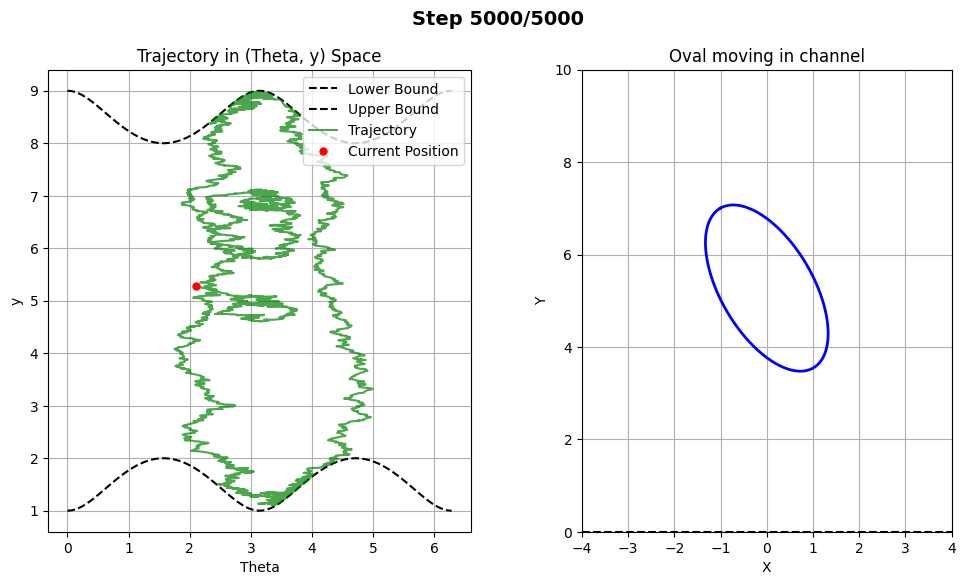

In [24]:
# For plotting a single trajectory to see how it's working out
from IPython.display import display, clear_output
import time

def build_oval(a, b, theta=0, y=0):
    """Generates the coordinates for an oval rotated by theta and shifted to height y."""
    t = np.linspace(0, 2 * np.pi, 360)
    x_coords = a * np.cos(t)  
    y_coords = b * np.sin(t) 

    # Apply rotation matrix
    c, s = np.cos(theta), np.sin(theta)
    x_coords_rot = c * x_coords - s * y_coords
    y_coords_rot = s * x_coords + c * y_coords

    # Translate vertically to match y-position
    y_coords_rot += y  

    return x_coords_rot, y_coords_rot

def animate_trajectory_and_oval(trajectory, a=1, b=0.5, lower_bounds=None, upper_bounds=None, xlim=None, ylim=None, dt=0.05):

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    
    if xlim is None:
        xlim = (np.min(trajectory[:, 0]) - 1, np.max(trajectory[:, 0]) + 1)
    if ylim is None:
        ylim = (np.min(trajectory[:, 1]) - 1, np.max(trajectory[:, 1]) + 1)
    
    ax1.set_xlim(*xlim)
    ax1.set_ylim(*ylim)
    ax2.set_xlim(-2*a, 2*a)  # Adjust horizontal limits based on oval size
    ax2.set_ylim(*ylim)

    for step_i in range(len(trajectory)):
        # Clear previous frame
        clear_output(wait=True)
        ax1.clear()
        ax2.clear()

        # Update oval plot bounds because it clears them every time
        ax2.set_xlim(-2*a, 2*a)
        ax2.set_ylim(*ylim)

        # Extract current values
        theta, y = trajectory[step_i]

        # Extract trajectory so far
        x_vals = trajectory[:step_i+1, 0]
        y_vals = trajectory[:step_i+1, 1]

        # Plot bounds on trajectory space
        if lower_bounds is not None:
            ax1.plot(lower_bounds[0], lower_bounds[1], 'k--', label="Lower Bound")
        
        if upper_bounds is not None:
            ax1.plot(upper_bounds[0], upper_bounds[1], 'k--', label="Upper Bound")

        # Plot the trajectory in (theta, y) space
        ax1.plot(x_vals, y_vals, 'g-', lw=1.5, alpha=0.7, label="Trajectory")  # Past trajectory
        ax1.plot(theta, y, 'ro', ms=5, label="Current Position")  # Moving point

        # Generate and plot the oval in real space
        oval_x, oval_y = build_oval(a, b, theta, y)
        ax2.plot(oval_x, oval_y, 'b-', lw=2, label="Oval")
        ax2.axhline(0, color='black', linestyle='--')  # Reference line

        # Set titles and labels
        ax1.set_title("Trajectory in (Theta, y) Space")
        ax1.set_xlabel("Theta")
        ax1.set_ylabel("y")
        ax1.legend()
        ax1.grid(True)

        ax2.set_title("Oval moving in channel")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")
        ax2.set_aspect('equal', 'box')
        # ax2.legend()
        ax2.grid(True)

        # title
        fig.suptitle(f"Step {step_i+1}/{len(trajectory)}", fontsize=14, fontweight='bold')

        # Display updated figure
        display(fig)
        time.sleep(dt)  # Control animation speed

    plt.close(fig)  # Close figure after animation completes

x_grid = np.linspace(0, W, 101)
animate_trajectory_and_oval(trajectories[0], a=a, b=b, lower_bounds=[x_grid, lower_bound(a, b, x_grid)],
                            upper_bounds=[x_grid, upper_bound(a, b, x_grid)], xlim=[-5, 5], ylim=[0,10],
                            dt=0.01)

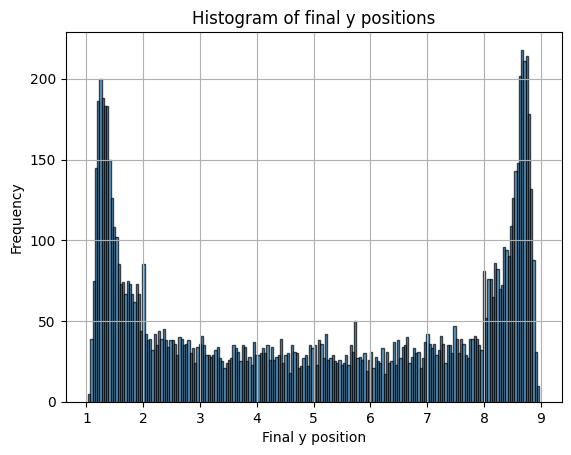

In [29]:
# Plot histograms
final_y_positions = [sim[-1, 1] for sim in trajectories]

plt.hist(final_y_positions, bins=200, edgecolor='black', alpha=0.7)
plt.xlabel("Final y position")
plt.ylabel("Frequency")
plt.title("Histogram of final y positions")
plt.grid(True)
plt.show()
